
                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 3, 1, 3)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 3, 1, 3)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.02s
     DAI_balance  ETH_balance  LP_shares  simulation  subset  run  substep   
0           6000          300        300           0       0    1        0  \
1           6000          300        297           0       0    1        1   
2           6003          300        297           0       0    1        2   
3           6003          300        295           0       0    1        1   
4           6007          300        295           0       0    1 

Text(0, 0.5, 'LP supply')

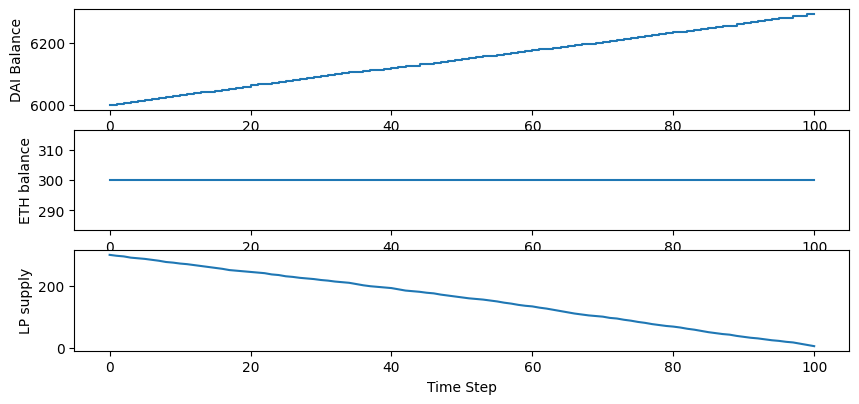

In [85]:
import pandas as pd
pd.set_option('max_colwidth', 70)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

lambda_token_deposit_rate = 5000  # average rate of swaps(token deposit) per unit time
lambda_ELTK_deposit_rate = 1000  # average rate of swaps(eth deposit) per unit time
mu_rate = 40000000  # average rate of liquidity additions per unit time
nu_rate = 0  # average rate of liquidity removals per unit time
RUNS=1
TIMESTEPS=100

state = {
    'DAI_balance': 6000,
    'ETH_balance': 300
}
state['LP_shares'] = state['ETH_balance']
params = {
    'fee_numerator': [997],
    'fee_denominator': [1000],
    'dt':[0.1]
}

#Add liquidity
def addLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    eth_reserve = int(current_state['ETH_balance'])
    liquidity_minted = int(input_['eth_deposit'] * total_liquidity // eth_reserve)
    return {'LP_shares': total_liquidity + liquidity_minted}

def addLiquidity_ETH(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + input_['eth_deposit'])

def addLiquidity_DAI(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if input_['eth_deposit'] == 0:
        token_amount = 0
    else:
        token_amount = int(input_['eth_deposit'] * token_reserve // eth_reserve + 1)
    return ('DAI_balance', token_reserve + token_amount)

#Remove liquidity
def removeLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    amount = int(input_['LP_burn'])
    return ('LP_shares', int(total_liquidity - amount))

def removeLiquidity_ETH(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    eth_reserve = int(current_state['ETH_balance'])
    amount = int(input_['LP_burn'])
    eth_amount = int(amount * eth_reserve // total_liquidity)
    return ('ETH_balance', int(eth_reserve - eth_amount))

def removeLiquidity_DAI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    token_reserve = int(current_state['DAI_balance'])
    amount = int(input_['LP_burn'])
    token_amount = int(amount * token_reserve // total_liquidity)
    return ('DAI_balance', int(token_reserve - token_amount))

#Price(Helper function)
def getInputPrice(input_amount, input_reserve, output_reserve, params):
    fee_numerator = params['fee_numerator']
    fee_denominator = params['fee_denominator']
    input_amount_with_fee = input_amount * fee_numerator
    numerator = input_amount_with_fee * output_reserve
    denominator = (input_reserve * fee_denominator) + input_amount_with_fee
    return int(numerator // denominator)

#Swap deposit ETH, withdraw token
#Eth sold/deposited
def ethToToken_ETH(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + eth_sold)

#DAI received
def ethToToken_DAI(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if eth_sold == 0:
        return ('DAI_balance', token_reserve)
    else:
        tokens_bought = int(getInputPrice(eth_sold, eth_reserve, token_reserve, params))
        return ('DAI_balance', token_reserve - tokens_bought)

 #Swap deposit token,withdraw ETH
 #Eth recieved   
def tokenToEth_ETH(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    if tokens_sold == 0:
        return ('ETH_balance', eth_reserve)
    else:
        token_reserve = int(current_state['DAI_balance'])
        eth_bought = int(getInputPrice(tokens_sold, token_reserve, eth_reserve, params))
        return ('ETH_balance', eth_reserve - eth_bought)

 #tokens sold/depoisted   
def tokenToEth_DAI(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    token_reserve = int(current_state['DAI_balance'])
    return ('DAI_balance', token_reserve + tokens_sold)
"""""
#Policy functions
def deposit_policy(params, step, sH, s):
    token_deposit_amount = np.random.uniform(low=200, high=500)
    return {'eth_deposit': token_deposit_amount}

def withdraw_policy(params, step, sH, s):
    token_withdraw_amount =(-1)* np.random.uniform(low=200, high=500)*0.5
    return {'tokens_sold': token_withdraw_amount}

def eth_withdraw_policy(params, step, sH, s):
    token_withdraw_amount =(-1)* np.random.uniform(low=200, high=500)*0.5
    return {'eth_sold': token_withdraw_amount}

def add_liquidity_policy(params,step,sH,s):
    add_liquidity_token=np.random.uniform(low=200,high=500)
    return{'LP_burn':add_liquidity_token}
"""
# Policy functions
def add_liquiidty_policy(params, step, sH, s):
    #eth_deposit = np.random.poisson(mu_rate)*params['dt']
    eth_deposit = np.random.uniform(low=2, high=5)
    return {'eth_deposit': eth_deposit}

def tokens_sold_policy(params, step, sH, s):
    #tokens_sold = np.random.poisson(lambda_token_deposit_rate)*params['dt']
    tokens_sold = np.random.uniform(low=2, high=5)
    return {'tokens_sold': tokens_sold}

def eth_sold_policy(params, step, sH, s):
    #eth_sold = np.random.poisson(lambda_eth_deposit_rate)*params['dt']
    eth_sold = np.random.uniform(low=2, high=5)
    return {'eth_sold': eth_sold}

def remove_liquidity_policy(params,step,sH,s):
    #LP_burn = np.random.poisson(nu_rate)*params['dt']
    LP_burn = np.random.uniform(low=2, high=5)
    return{'LP_burn':LP_burn}

policies1 = {
    #'token_sold': tokens_sold_policy,
    #'eth_sold': eth_sold_policy,
    'LP_burn': remove_liquidity_policy,
    'eth_deposit':add_liquiidty_policy
}
policies2 = {
    'eth_sold': eth_sold_policy,
    'token_sold': tokens_sold_policy
    
    #'LP_burn': remove_liquidity_policy,
    #'eth_deposit':add_liquiidty_policy
}


# Partial State Update Blocks
partial_state_update_blocks = [
    {
        'label': 'Add/Remove Liquidity dynamics',
        'ignore': False,
        'debug': True,
        'policies': policies1,
        'variables': {
            'LP_shares': addLiquidity_LP,
            'LP_shares':removeLiquidity_LP
            #'ETH_balance':addLiquidity_LP,
            #'ETH_balance':removeLiquidity_LP,
            #'ETH_balance':ethToToken_ETH,
            #'ETH_balance':tokenToEth_ETH,
            #'DAI_balance': addLiquidity_LP,
            #'DAI_balance':removeLiquidity_LP
            #'DAI_balance':ethToToken_DAI,
            #'DAI_balance':tokenToEth_DAI
        }
    },
    {
        'label': 'Swap dynamics',
        'ignore': False,
        'debug': True,
        'policies': policies2,
        'variables': {
            #'LP_shares': addLiquidity_LP,
            #'LP_shares':removeLiquidity_LP,
            #'ETH_balance':addLiquidity_LP,
            #'ETH_balance':removeLiquidity_LP,
            'ETH_balance':ethToToken_ETH,
            'ETH_balance':tokenToEth_ETH,
            #'DAI_balance': addLiquidity_LP,
            #'DAI_balance':removeLiquidity_LP,
            'DAI_balance':ethToToken_DAI,
            'DAI_balance':tokenToEth_DAI
        }
    }
]

# Simulation Parameters
sim_config = {
    'N': RUNS,
    'T': range(TIMESTEPS),
    'M': params
}
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)
print(df)
plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(df['timestep'], df['DAI_balance'])
plt.xlabel('Time Step')
plt.ylabel('DAI Balance')

plt.subplot(4, 1, 2)
plt.plot(df['timestep'], df['ETH_balance'])
plt.xlabel('Time Step')
plt.ylabel('ETH balance')

plt.subplot(4, 1, 3)
plt.plot(df['timestep'], df['LP_shares'])
plt.xlabel('Time Step')
plt.ylabel('LP supply')


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 2, 5, 3)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 2, 5, 3)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 6.80s


Text(0, 0.5, 'LP supply')

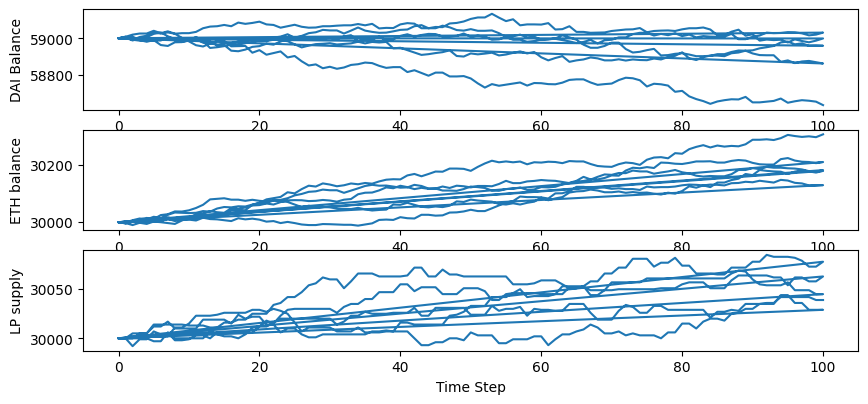

In [7]:
import pandas as pd
pd.set_option('max_colwidth', 70)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

lambda_rate = 5000  # average rate of swaps per unit time
mu_rate = 3000  # average rate of liquidity additions per unit time
nu_rate = 500  # average rate of liquidity removals per unit time
TIMESTEPS=100
RUNS=5

state = {
    'DAI_balance': 59000,
    'ETH_balance': 30000
}
state['LP_shares'] = state['ETH_balance']
params = {
    'fee_numerator': [997],
    'fee_denominator': [1000]
}

#Add liquidity
def addLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    eth_reserve = int(current_state['ETH_balance'])
    liquidity_minted = int(input_['eth_deposit'] * total_liquidity // eth_reserve)
    return ('LP_shares', total_liquidity + liquidity_minted)

def addLiquidity_ETH(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + input_['eth_deposit'])

def addLiquidity_DAI(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if input_['eth_deposit'] == 0:
        token_amount = 0
    else:
        token_amount = int(input_['eth_deposit'] * token_reserve // eth_reserve + 1)
    return ('DAI_balance', token_reserve + token_amount)


#Remove liquidity
def removeLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    amount = int(input_['LP_burn'])
    return ('LP_shares', int(total_liquidity - amount))

def removeLiquidity_ETH(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    eth_reserve = int(current_state['ETH_balance'])
    amount = int(input_['LP_burn'])
    eth_amount = int(amount * eth_reserve // total_liquidity)
    return ('ETH_balance', int(eth_reserve - eth_amount))

def removeLiquidity_DAI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    token_reserve = int(current_state['DAI_balance'])
    amount = int(input_['LP_burn'])
    token_amount = int(amount * token_reserve // total_liquidity)
    return ('DAI_balance', int(token_reserve - token_amount))

#Price(Helper function)
def getInputPrice(input_amount, input_reserve, output_reserve, params):
    fee_numerator = params['fee_numerator']
    fee_denominator = params['fee_denominator']
    input_amount_with_fee = input_amount * fee_numerator
    numerator = input_amount_with_fee * output_reserve
    denominator = (input_reserve * fee_denominator) + input_amount_with_fee
    return int(numerator // denominator)

#Swap ETH-token
#Eth sold/deposited
def ethToToken_ETH(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + eth_sold)

#DAI received
def ethToToken_DAI(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if eth_sold == 0:
        return ('DAI_balance', token_reserve)
    else:
        tokens_bought = int(getInputPrice(eth_sold, eth_reserve, token_reserve, params))
        return ('DAI_balance', token_reserve - tokens_bought)

 #Swap token-ETH
 #Eth recieved   
def tokenToEth_ETH(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    if tokens_sold == 0:
        return ('ETH_balance', eth_reserve)
    else:
        token_reserve = int(current_state['DAI_balance'])
        eth_bought = int(getInputPrice(tokens_sold, token_reserve, eth_reserve, params))
        return ('ETH_balance', eth_reserve - eth_bought)

 #tokens sold/depoisted   
def tokenToEth_DAI(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    token_reserve = int(current_state['DAI_balance'])
    return ('DAI_balance', token_reserve + tokens_sold)


import random
def actionDecoder(params, step, history, current_state):
    
    prev_timestep = current_state['timestep']
    if step > 1:
        prev_timestep -= 1
        
    #skip the first two events, as they are already accounted for in the initial conditions of the system
    data_counter = prev_timestep + 2 
    
    action = {
        'eth_sold': 0,
        'tokens_sold': 0,
        'eth_deposit': 0,
        'LP_burn': 0,        
    }
    
    # Generate a random event
    events = ['TokenPurchase', 'EthPurchase', 'AddLiquidity', 'Transfer']
    event = random.choice(events)
    
    action['action_id'] = event
    
    if event == 'TokenPurchase':
        # Set random values for eth_sold
        action['eth_sold'] = random.uniform(0, 20)
    elif event == 'EthPurchase':
        # Set random values for tokens_sold
        action['tokens_sold'] = random.uniform(0, 10)
    elif event == 'AddLiquidity':
        # Set random values for eth_deposit
        action['eth_deposit'] = random.uniform(0, 10)
    elif event == 'Transfer':
        # Set random values for UNI_burn
        action['LP_burn'] = random.uniform(0, 10)

    return action
def mechanismHub_DAI(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_DAI(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_DAI(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_DAI(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_DAI(params, step, history, current_state, input_)
    return('DAI_balance', current_state['DAI_balance'])
    
def mechanismHub_ETH(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_ETH(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_ETH(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_ETH(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_ETH(params, step, history, current_state, input_)
    return('ETH_balance', current_state['ETH_balance'])

def mechanismHub_LP(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'AddLiquidity':
        return addLiquidity_LP(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_LP(params, step, history, current_state, input_)
    return('LP_shares', current_state['LP_shares'])
    

partial_state_update_blocks = [
    {
        'policies': {
            'user_action': actionDecoder
        },
        'variables': {
            'DAI_balance': mechanismHub_DAI,
            'ETH_balance': mechanismHub_ETH,
            'LP_shares': mechanismHub_LP
        }
    }
]
# Simulation Parameters
sim_config = {
    'N': RUNS,
    'T': range(TIMESTEPS),
    'M': params
}
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)
plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(df['timestep'], df['DAI_balance'])
plt.xlabel('Time Step')
plt.ylabel('DAI Balance')

plt.subplot(4, 1, 2)
plt.plot(df['timestep'], df['ETH_balance'])
plt.xlabel('Time Step')
plt.ylabel('ETH balance')

plt.subplot(4, 1, 3)
plt.plot(df['timestep'], df['LP_shares'])
plt.xlabel('Time Step')
plt.ylabel('LP supply')


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 2, 4, 3)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 2, 4, 3)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 6.04s


Text(0, 0.5, 'LP supply')

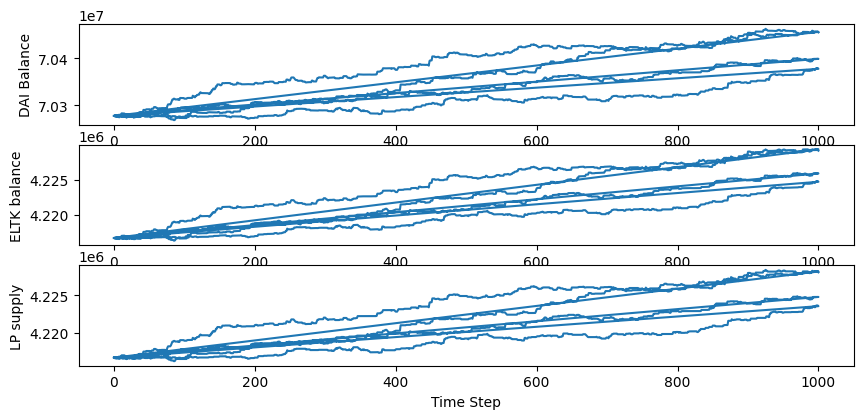

In [17]:
import pandas as pd
pd.set_option('max_colwidth', 70)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

lambda_rate = 5000  # average rate of swaps per unit time
mu_rate = 3000  # average rate of liquidity additions per unit time
nu_rate = 500  # average rate of liquidity removals per unit time
TIMESTEPS=1000
RUNS=2

state = {
    'DAI_balance': 70277778,
    'ELTK_balance': 4216667
}
state['LP_shares'] = state['ELTK_balance']
params = {
    'fee_numerator': [997,985],
    'fee_denominator': [1000]
}

#Add liquidity
def addLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    ELTK_reserve = int(current_state['ELTK_balance'])
    liquidity_minted = int(input_['ELTK_deposit'] * total_liquidity // ELTK_reserve)
    return ('LP_shares', total_liquidity + liquidity_minted)

def addLiquidity_ELTK(params, step, history, current_state, input_):
    ELTK_reserve = int(current_state['ELTK_balance'])
    return ('ELTK_balance', ELTK_reserve + input_['ELTK_deposit'])

def addLiquidity_DAI(params, step, history, current_state, input_):
    ELTK_reserve = int(current_state['ELTK_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if input_['ELTK_deposit'] == 0:
        token_amount = 0
    else:
        token_amount = int(input_['ELTK_deposit'] * token_reserve // ELTK_reserve + 1)
    return ('DAI_balance', token_reserve + token_amount)


#Remove liquidity
def removeLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    amount = int(input_['LP_burn'])
    return ('LP_shares', int(total_liquidity - amount))

def removeLiquidity_ELTK(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    ELTK_reserve = int(current_state['ELTK_balance'])
    amount = int(input_['LP_burn'])
    ELTK_amount = int(amount * ELTK_reserve // total_liquidity)
    return ('ELTK_balance', int(ELTK_reserve - ELTK_amount))

def removeLiquidity_DAI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    token_reserve = int(current_state['DAI_balance'])
    amount = int(input_['LP_burn'])
    token_amount = int(amount * token_reserve // total_liquidity)
    return ('DAI_balance', int(token_reserve - token_amount))

#Price(Helper function)
def getInputPrice(input_amount, input_reserve, output_reserve, params):
    fee_numerator = params['fee_numerator']
    fee_denominator = params['fee_denominator']
    input_amount_with_fee = input_amount * fee_numerator
    numerator = input_amount_with_fee * output_reserve
    denominator = (input_reserve * fee_denominator) + input_amount_with_fee
    return int(numerator // denominator)

#Swap ELTK-token
#ELTK sold/deposited
def ELTKToToken_ELTK(params, step, history, current_state, input_):
    ELTK_sold = int(input_['ELTK_sold']) #amount of ELTK being sold by the user
    ELTK_reserve = int(current_state['ELTK_balance'])
    return ('ELTK_balance', ELTK_reserve + ELTK_sold)

#DAI received
def ELTKToToken_DAI(params, step, history, current_state, input_):
    ELTK_sold = int(input_['ELTK_sold']) #amount of ELTK being sold by the user
    ELTK_reserve = int(current_state['ELTK_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if ELTK_sold == 0:
        return ('DAI_balance', token_reserve)
    else:
        tokens_bought = int(getInputPrice(ELTK_sold, ELTK_reserve, token_reserve, params))
        return ('DAI_balance', token_reserve - tokens_bought)

 #Swap token-ELTK
 #ELTK recieved   
def tokenToELTK_ELTK(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    ELTK_reserve = int(current_state['ELTK_balance'])
    if tokens_sold == 0:
        return ('ELTK_balance', ELTK_reserve)
    else:
        token_reserve = int(current_state['DAI_balance'])
        ELTK_bought = int(getInputPrice(tokens_sold, token_reserve, ELTK_reserve, params))
        return ('ELTK_balance', ELTK_reserve - ELTK_bought)

 #tokens sold/depoisted   
def tokenToELTK_DAI(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    token_reserve = int(current_state['DAI_balance'])
    return ('DAI_balance', token_reserve + tokens_sold)


import random
import numpy as np

def actionDecoder(params, step, history, current_state):
    
    prev_timestep = current_state['timestep']
    if step > 1:
        prev_timestep -= 1
        
    #skip the first two events, as they are already accounted for in the initial conditions of the system
    data_counter = prev_timestep + 2 
    
    action = {
        'ELTK_sold': 0,
        'tokens_sold': 0,
        'ELTK_deposit': 0,
        'LP_burn': 0,        
    }
    
    # Generate a random event based on probability distribution
    events = ['TokenPurchase', 'ELTKPurchase', 'AddLiquidity', 'Transfer']
    event_probabilities = [0.4, 0.3, 0.2, 0.1]  # Example probabilities for each event
    event = np.random.choice(events, p=event_probabilities)
    
    action['action_id'] = event
    
    if event == 'TokenPurchase':
        # Generate random values for eLTK_sold using a specific distribution
        ELTK_sold = np.random.normal(loc=5, scale=2)  # Example using normal distribution
        action['ELTK_sold'] = max(ELTK_sold, 0)  # Ensure non-negative value
    elif event == 'ELTKPurchase':
        # Generate random values for tokens_sold using a specific distribution
        tokens_sold = np.random.uniform(0, 100)  # Example using uniform distribution
        action['tokens_sold'] = tokens_sold
    elif event == 'AddLiquidity':
        # Generate random values for ELTK_deposit using a specific distribution
        ELTK_deposit = np.random.exponential(scale=100)  # Example using exponential distribution
        action['ELTK_deposit'] = ELTK_deposit
    elif event == 'Transfer':
        # Generate random values for LP_burn using a specific distribution
        LP_burn = np.random.poisson(lam=100)  # Example using Poisson distribution
        action['LP_burn'] = LP_burn

    return action

def mechanismHub_DAI(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ELTKToToken_DAI(params, step, history, current_state, input_)
    elif action == 'ELTKPurchase':
        return tokenToELTK_DAI(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_DAI(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_DAI(params, step, history, current_state, input_)
    return('DAI_balance', current_state['DAI_balance'])
    
def mechanismHub_ELTK(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ELTKToToken_ELTK(params, step, history, current_state, input_)
    elif action == 'ELTKPurchase':
        return tokenToELTK_ELTK(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_ELTK(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_ELTK(params, step, history, current_state, input_)
    return('ELTK_balance', current_state['ELTK_balance'])

def mechanismHub_LP(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'AddLiquidity':
        return addLiquidity_LP(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_LP(params, step, history, current_state, input_)
    return('LP_shares', current_state['LP_shares'])
    

partial_state_update_blocks = [
    {
        'policies': {
            'user_action': actionDecoder
        },
        'variables': {
            'DAI_balance': mechanismHub_DAI,
            'ELTK_balance': mechanismHub_ELTK,
            'LP_shares': mechanismHub_LP
        }
    }
]
# Simulation Parameters
sim_config = {
    'N': RUNS,
    'T': range(TIMESTEPS),
    'M': params
}
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)
plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(df['timestep'], df['DAI_balance'])
plt.xlabel('Time Step')
plt.ylabel('DAI Balance')

plt.subplot(4, 1, 2)
plt.plot(df['timestep'], df['ELTK_balance'])
plt.xlabel('Time Step')
plt.ylabel('ELTK balance')

plt.subplot(4, 1, 3)
plt.plot(df['timestep'], df['LP_shares'])
plt.xlabel('Time Step')
plt.ylabel('LP supply')


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 4, 3, 5)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 4, 3, 5)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 4.91s


Text(0, 0.5, 'token_price')

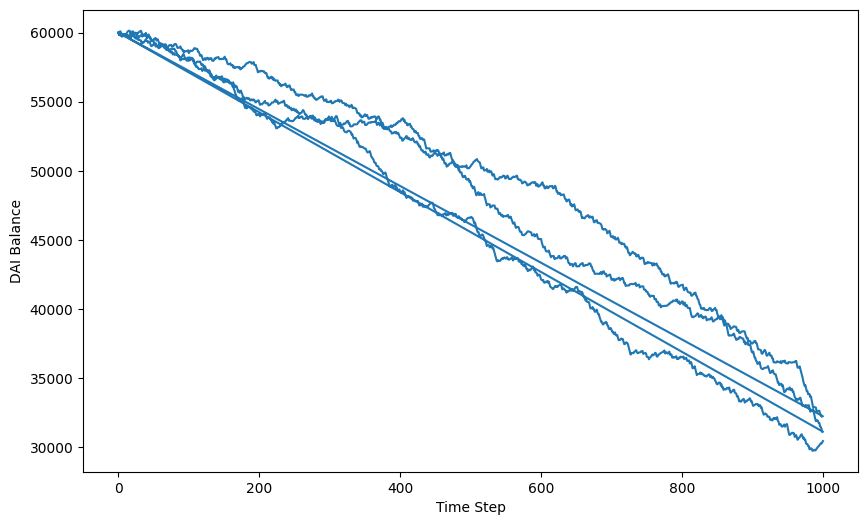

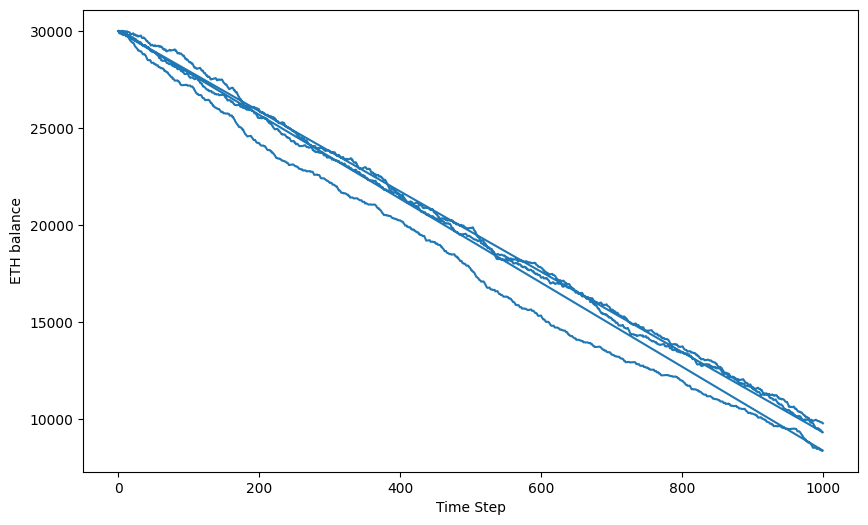

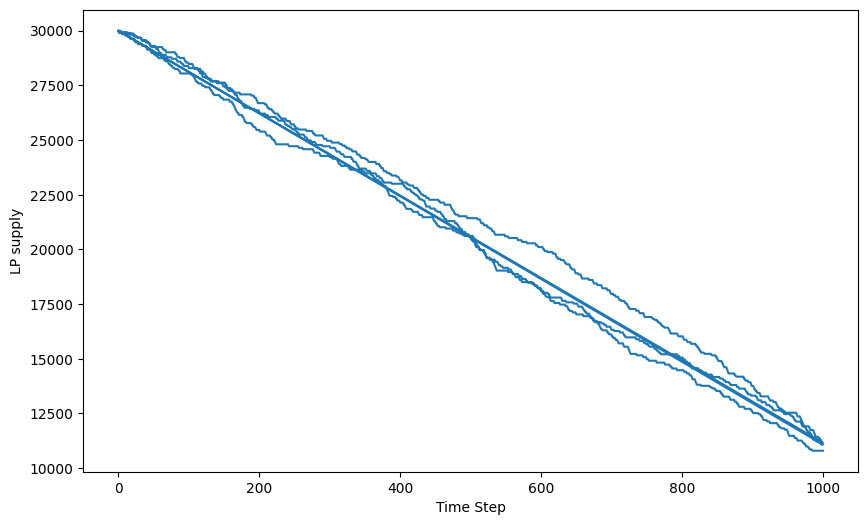

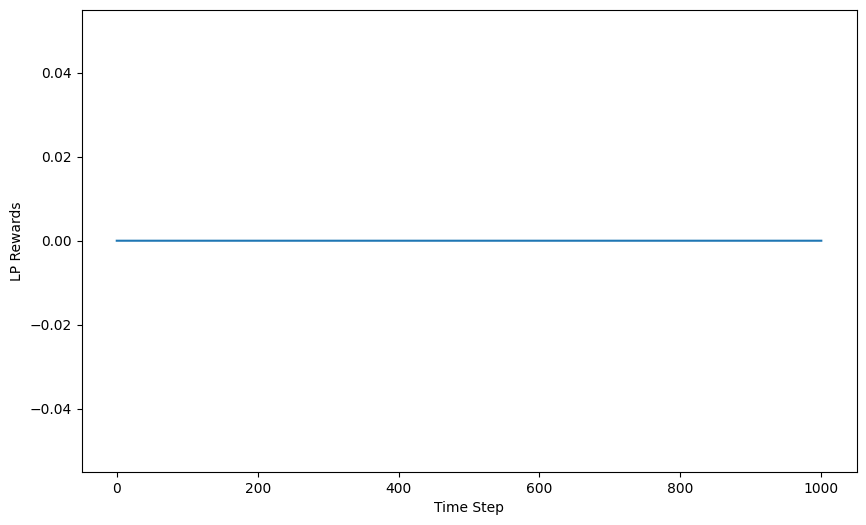

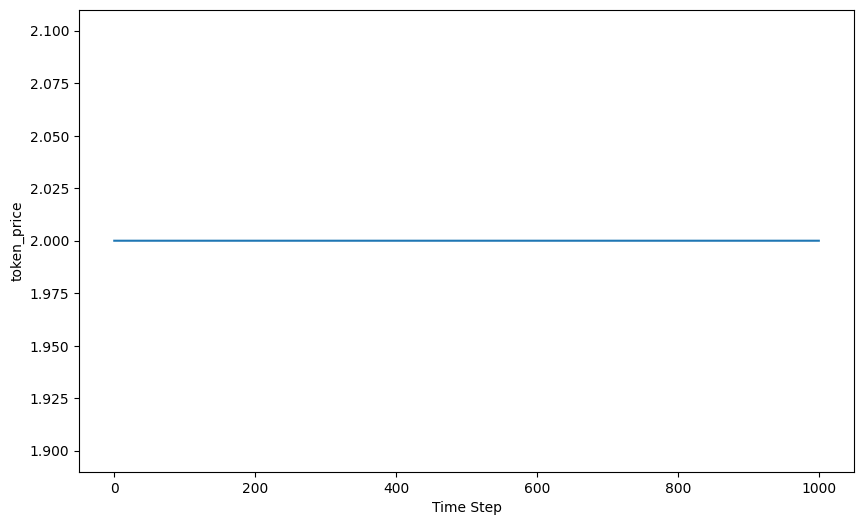

In [16]:
import pandas as pd
pd.set_option('max_colwidth', 70)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

lambda_rate = 5000  # average rate of swaps per unit time
mu_rate = 3000  # average rate of liquidity additions per unit time
nu_rate = 500  # average rate of liquidity removals per unit time
TIMESTEPS=1000
RUNS=1

state = {
    'DAI_balance': 60000,
    'ETH_balance': 30000,
    'LP_rewards':0,
}
state['LP_shares'] = state['ETH_balance']
state['token_price']=int(state['DAI_balance']/state['ETH_balance'])

params = {
    'fee_numerator': [997],
    'fee_denominator': [1000],
    'adoption_scnarios':[0.5,1,1.5],
    'reward_rate':[3]
}

def update_token_price(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance']+input_['tokens_sold'])
    dai_reserve = int(current_state['DAI_balance'])
    new_price=dai_reserve//eth_reserve
    return (new_price)

#Add liquidity
def addLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    eth_reserve = int(current_state['ETH_balance'])
    liquidity_minted = int(input_['eth_deposit'] * total_liquidity // eth_reserve)
    lp_rewards = liquidity_minted * params['reward_rate']
    return total_liquidity + liquidity_minted, current_state['LP_rewards'] + lp_rewards

def addLiquidity_ETH(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + input_['eth_deposit'])

def addLiquidity_DAI(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if input_['eth_deposit'] == 0:
        token_amount = 0
    else:
        token_amount = int(input_['eth_deposit'] * token_reserve // eth_reserve + 1)
    return ('DAI_balance', token_reserve + token_amount)


#Remove liquidity
def removeLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    amount = int(input_['LP_burn'])
    return ('LP_shares', int(total_liquidity - amount))

def removeLiquidity_ETH(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    eth_reserve = int(current_state['ETH_balance'])
    amount = int(input_['LP_burn'])
    eth_amount = int(amount * eth_reserve // total_liquidity)
    return ('ETH_balance', int(eth_reserve - eth_amount))

def removeLiquidity_DAI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    token_reserve = int(current_state['DAI_balance'])
    amount = int(input_['LP_burn'])
    token_amount = int(amount * token_reserve // total_liquidity)
    return ('DAI_balance', int(token_reserve - token_amount))

#Price(Helper function)
def getInputPrice(input_amount, input_reserve, output_reserve, params):
    fee_numerator = params['fee_numerator']
    fee_denominator = params['fee_denominator']
    input_amount_with_fee = input_amount * fee_numerator
    numerator = input_amount_with_fee * output_reserve
    denominator = (input_reserve * fee_denominator) + input_amount_with_fee
    return int(numerator // denominator)

#Swap ETH-token
#Eth sold/deposited
def ethToToken_ETH(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + eth_sold)

#DAI received
def ethToToken_DAI(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if eth_sold == 0:
        return ('DAI_balance', token_reserve)
    else:
        tokens_bought = int(getInputPrice(eth_sold, eth_reserve, token_reserve, params))
        return ('DAI_balance', token_reserve - tokens_bought)

 #Swap token-ETH
 #Eth recieved   
def tokenToEth_ETH(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    if tokens_sold == 0:
        return ('ETH_balance', eth_reserve)
    else:
        token_reserve = int(current_state['DAI_balance'])
        eth_bought = int(getInputPrice(tokens_sold, token_reserve, eth_reserve, params))
        return ('ETH_balance', eth_reserve - eth_bought)

 #tokens sold/depoisted   
def tokenToEth_DAI(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    token_reserve = int(current_state['DAI_balance'])
    return ('DAI_balance', token_reserve + tokens_sold)


import random
def actionDecoder(params, step, history, current_state):
    
    prev_timestep = current_state['timestep']
    if step > 1:
        prev_timestep -= 1
        
    #skip the first two events, as they are already accounted for in the initial conditions of the system
    data_counter = prev_timestep + 2 
    
    action = {
        'eth_sold': 0,
        'tokens_sold': 0,
        'eth_deposit': 0,
        'LP_burn': 0,        
    }
    
    # Generate a random event
    events = ['TokenPurchase', 'EthPurchase', 'AddLiquidity', 'Transfer']
    event = random.choice(events)
    
    action['action_id'] = event
    
    if event == 'TokenPurchase':
        # Set random values for eth_sold
        action['eth_sold'] = random.uniform(0, 20)*params['adoption_scnarios']
    elif event == 'EthPurchase':
        # Set random values for tokens_sold
        action['tokens_sold'] = random.uniform(50, 100)
    elif event == 'AddLiquidity':
        # Set random values for eth_deposit
        action['eth_deposit'] = random.uniform(0, 10)*params['adoption_scnarios']
    elif event == 'Transfer':
        # Set random values for UNI_burn
        action['LP_burn'] = random.uniform(50, 100)

    return action

def mechanismHub_DAI(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_DAI(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_DAI(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_DAI(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_DAI(params, step, history, current_state, input_)
    return('DAI_balance', current_state['DAI_balance'])
    
def mechanismHub_ETH(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_ETH(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_ETH(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_ETH(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_ETH(params, step, history, current_state, input_)
    return('ETH_balance', current_state['ETH_balance'])

def mechanismHub_LP(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'AddLiquidity':
        return addLiquidity_LP(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_LP(params, step, history, current_state, input_)
    return('LP_shares', current_state['LP_shares'])
    

partial_state_update_blocks = [
    {
        'policies': {
            'user_action': actionDecoder
        },
        'variables': {
            'DAI_balance': mechanismHub_DAI,
            'ETH_balance': mechanismHub_ETH,
            'LP_shares': mechanismHub_LP

        }
    }
]
# Simulation Parameters
sim_config = {
    'N': RUNS,
    'T': range(TIMESTEPS),
    'M': params
}
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['DAI_balance'])
plt.xlabel('Time Step')
plt.ylabel('DAI Balance')

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['ETH_balance'])
plt.xlabel('Time Step')
plt.ylabel('ETH balance')

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['LP_shares'])
plt.xlabel('Time Step')
plt.ylabel('LP supply')

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['LP_rewards'])
plt.xlabel('Time Step')
plt.ylabel('LP Rewards')

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['token_price'])
plt.xlabel('Time Step')
plt.ylabel('token_price')


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 5, 4, 6)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 5, 4, 6)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 6.68s


Text(0, 0.5, 'token_price')

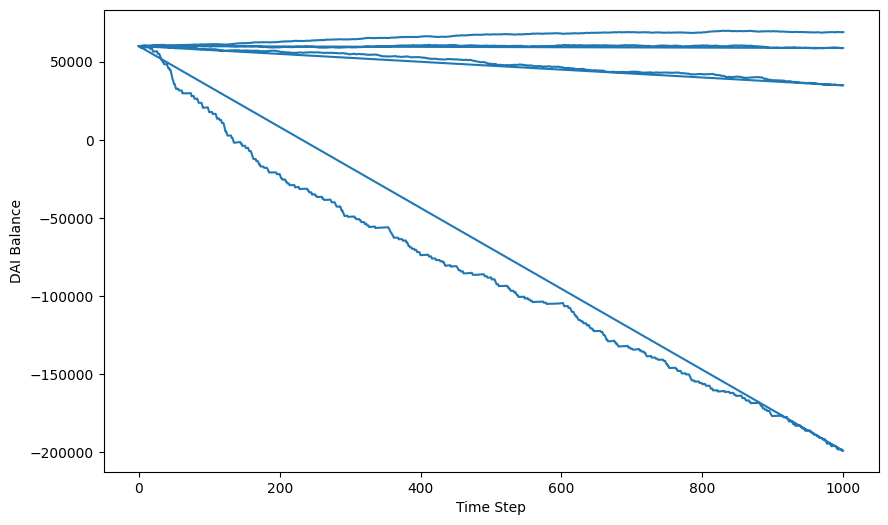

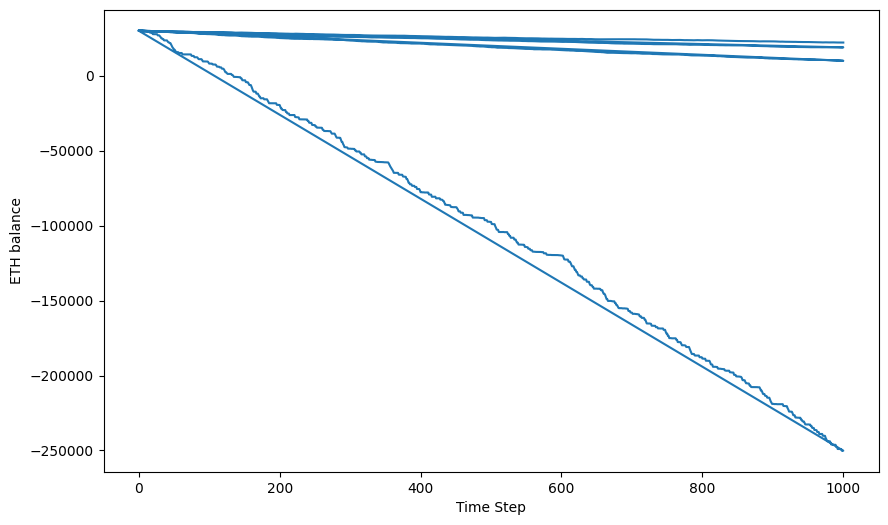

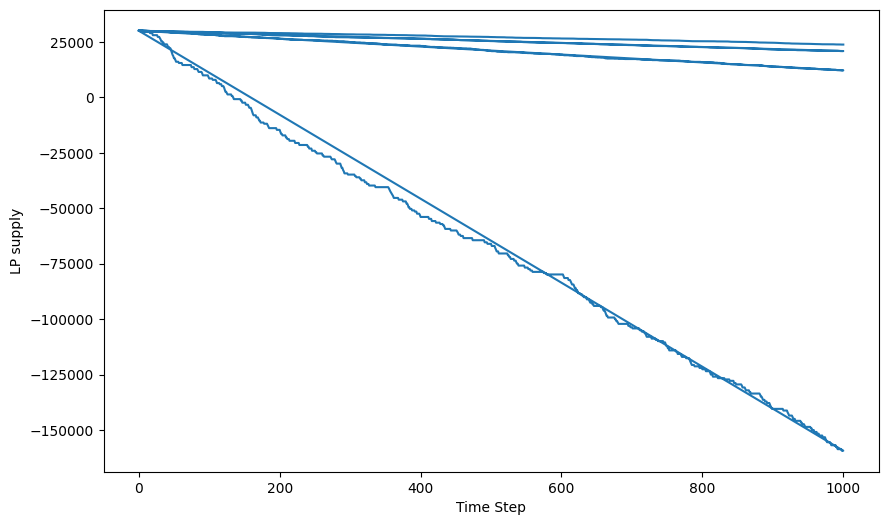

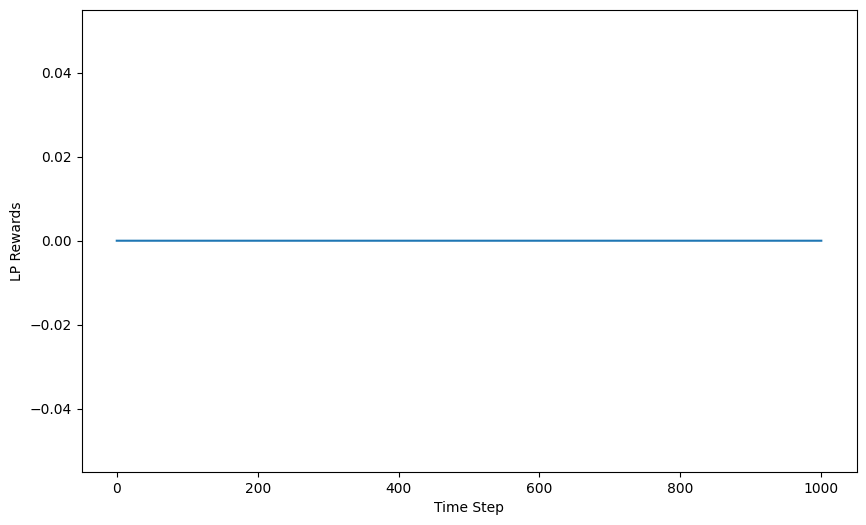

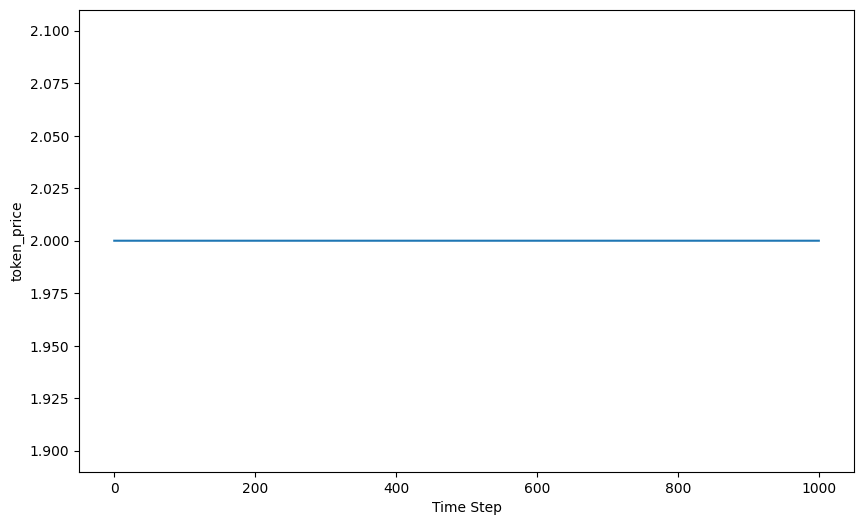

In [1]:
import pandas as pd
pd.set_option('max_colwidth', 70)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

lambda_rate = 5000  # average rate of swaps per unit time
mu_rate = 3000  # average rate of liquidity additions per unit time
nu_rate = 500  # average rate of liquidity removals per unit time
TIMESTEPS=1000
RUNS=1

state = {
    'DAI_balance': 60000,
    'ETH_balance': 30000,
    'LP_rewards':0,
    'tx_volume':0
}
state['LP_shares'] = state['ETH_balance']
state['token_price']=int(state['DAI_balance']/state['ETH_balance'])

params = {
    'fee_numerator': [997],
    'fee_denominator': [1000],
    'adoption_scnarios':[0.5],
    'reward_rate':[3],
    'LM_rewards':[0.1,1,2,3]
}

def update_token_price(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance']+input_['tokens_sold'])
    dai_reserve = int(current_state['DAI_balance'])
    new_price=dai_reserve//eth_reserve
    return (new_price)

#Add liquidity
def addLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    eth_reserve = int(current_state['ETH_balance'])
    liquidity_minted = int(input_['eth_deposit'] * total_liquidity // eth_reserve)
    lp_rewards = liquidity_minted * params['reward_rate']
    return total_liquidity + liquidity_minted, current_state['LP_rewards'] + lp_rewards

def addLiquidity_ETH(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + input_['eth_deposit'])

def addLiquidity_DAI(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if input_['eth_deposit'] == 0:
        token_amount = 0
    else:
        token_amount = int(input_['eth_deposit'] * token_reserve // eth_reserve + 1)
    return ('DAI_balance', token_reserve + token_amount)


#Remove liquidity
def removeLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    amount = int(input_['LP_burn'])
    return ('LP_shares', int(total_liquidity - amount))

def removeLiquidity_ETH(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    eth_reserve = int(current_state['ETH_balance'])
    amount = int(input_['LP_burn'])
    eth_amount = int(amount * eth_reserve // total_liquidity)
    return ('ETH_balance', int(eth_reserve - eth_amount))

def removeLiquidity_DAI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    token_reserve = int(current_state['DAI_balance'])
    amount = int(input_['LP_burn'])
    token_amount = int(amount * token_reserve // total_liquidity)
    return ('DAI_balance', int(token_reserve - token_amount))

#Price(Helper function)
def getInputPrice(input_amount, input_reserve, output_reserve, params):
    fee_numerator = params['fee_numerator']
    fee_denominator = params['fee_denominator']
    input_amount_with_fee = input_amount * fee_numerator
    numerator = input_amount_with_fee * output_reserve
    denominator = (input_reserve * fee_denominator) + input_amount_with_fee
    return int(numerator // denominator)

#Swap ETH-token
#Eth sold/deposited
def ethToToken_ETH(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + eth_sold)

#DAI received
def ethToToken_DAI(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if eth_sold == 0:
        return ('DAI_balance', token_reserve)
    else:
        tokens_bought = int(getInputPrice(eth_sold, eth_reserve, token_reserve, params))
        return ('DAI_balance', token_reserve - tokens_bought)

 #Swap token-ETH
 #Eth recieved   
def tokenToEth_ETH(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    if tokens_sold == 0:
        return ('ETH_balance', eth_reserve)
    else:
        token_reserve = int(current_state['DAI_balance'])
        eth_bought = int(getInputPrice(tokens_sold, token_reserve, eth_reserve, params))
        return ('ETH_balance', eth_reserve - eth_bought)

 #tokens sold/depoisted   
def tokenToEth_DAI(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    token_reserve = int(current_state['DAI_balance'])
    return ('DAI_balance', token_reserve + tokens_sold)


import random
#policy function
def actionDecoder(params, step, history, current_state):
    
    prev_timestep = current_state['timestep']
    if step > 1:
        prev_timestep -= 1
        
    #skip the first two events, as they are already accounted for in the initial conditions of the system
    data_counter = prev_timestep + 2 
    
    action = {
        'eth_sold': 0,
        'tokens_sold': 0,
        'eth_deposit': 0,
        'LP_burn': 0,        
    }
    
    # Generate a random event
    events = ['TokenPurchase', 'EthPurchase', 'AddLiquidity', 'Transfer']
    event = random.choice(events)
    
    action['action_id'] = event
    
    if event == 'TokenPurchase':
        # Set random values for eth_sold
        action['eth_sold'] = random.uniform(0, 20)*params['adoption_scnarios']
    elif event == 'EthPurchase':
        # Set random values for tokens_sold
        action['tokens_sold'] = random.uniform(50, 100)
    elif event == 'AddLiquidity':
        # Set random values for eth_deposit
        action['eth_deposit'] = random.uniform(0, 10)*params['LM_rewards']
    elif event == 'Transfer':
        # Set random values for UNI_burn
        action['LP_burn'] = random.uniform(50, 100)*(1/params['LM_rewards'])

    return action

def mechanismHub_DAI(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_DAI(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_DAI(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_DAI(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_DAI(params, step, history, current_state, input_)
    return('DAI_balance', current_state['DAI_balance'])
    
def mechanismHub_ETH(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_ETH(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_ETH(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_ETH(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_ETH(params, step, history, current_state, input_)
    return('ETH_balance', current_state['ETH_balance'])

def mechanismHub_LP(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'AddLiquidity':
        return addLiquidity_LP(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_LP(params, step, history, current_state, input_)
    return('LP_shares', current_state['LP_shares'])
    

partial_state_update_blocks = [
    {
        'policies': {
            'user_action': actionDecoder
        },
        'variables': {
            'DAI_balance': mechanismHub_DAI,
            'ETH_balance': mechanismHub_ETH,
            'LP_shares': mechanismHub_LP

        }
    }
]
# Simulation Parameters
sim_config = {
    'N': RUNS,
    'T': range(TIMESTEPS),
    'M': params
}
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['DAI_balance'])
plt.xlabel('Time Step')
plt.ylabel('DAI Balance')

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['ETH_balance'])
plt.xlabel('Time Step')
plt.ylabel('ETH balance')

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['LP_shares'])
plt.xlabel('Time Step')
plt.ylabel('LP supply')

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['LP_rewards'])
plt.xlabel('Time Step')
plt.ylabel('LP Rewards')

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['token_price'])
plt.xlabel('Time Step')
plt.ylabel('token_price')